# Convolutional Neural Network

Credits: Magnus Erik Hvass Pedersen

The original code can be found [here](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb). Only some minor updates were made.

## Starting with the imports

You will need matplotlib, numpy, scikit-learn, tensorflow and mnist-py. They can be install via pip:

`pip install matplotlib numpy scikit-learn tensorflow mnist-py`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from mnist import MNIST
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() # use tf v1 due to old code

2022-07-22 15:33:01.628369: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-22 15:33:01.628397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


## Basic settings

In [2]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

## load MNIST self

Important to mention: You have to download the mnist data beforehand.

You can just download the from this repo (state from 07/2022) or look for details [here](https://github.com/mattpetersen/mnist-py).

In [3]:
class customContainer():
	def __init__(self, mnist):
		self.train_images = mnist.train_set.images
		self.train_labels = mnist.train_set.labels
		self.test_images = mnist.test_set.images
		self.test_labels = mnist.test_set.labels

		self.test_labels_cls = np.zeros(len(self.test_labels), dtype=int)
		for index, value in enumerate(self.test_labels):
			self.test_labels_cls[index] = np.argmax(value)

In [4]:
# data set import
data = customContainer(MNIST())

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train_images)))
#print("- Validation-set:\t{}".format(data.num_val))
print("- Test-set:\t\t{}".format(len(data.test_images)))

# The number of pixels in each dimension of an image.
img_size = 28

# The images are stored in one-dimensional arrays of this length.
img_size_flat = len(data.train_images[0])

# Tuple with height and width of images used to reshape arrays.
img_shape = (28,28)

# Number of classes, one class for each of 10 digits.
num_classes = 10

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

Size of:
- Training-set:		60000
- Test-set:		10000


## Some helper functions

Plotting nine images with classification lables.

In [5]:
def plot_images(images, cls_true, cls_pred=None):
	"""
	Plot hand written number with label
	"""
	assert len(images) == len(cls_true) == 9
	
	# Create figure with 3x3 sub-plots.
	fig, axes = plt.subplots(3, 3)
	fig.subplots_adjust(hspace=0.3, wspace=0.3)

	for i, ax in enumerate(axes.flat):
		# Plot image.
		ax.imshow(images[i].reshape(img_shape), cmap='binary')

		# Show true and predicted classes.
		if cls_pred is None:
			xlabel = "True: {0}".format(cls_true[i])
		else:
			xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

		# Show the classes as the label on the x-axis.
		ax.set_xlabel(xlabel)
		
		# Remove ticks from the plot.
		ax.set_xticks([])
		ax.set_yticks([])
	
	# Ensure the plot is shown correctly with multiple plots
	# in a single Notebook cell.
	plt.show()

Creating new weights and biases.

In [6]:
def new_weights(shape): # retruns random values 
	return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length): # returns a constant value with given shape/length
	return tf.Variable(tf.constant(0.05, shape=[length]))

### Creating a new convolutional layer

In [7]:
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):
	"""
	Creates a new convolutional layer.

	Parameters
	-
	input = the previous layer,\n
	num_input_channels = number of channels in prev. layer, \n
	filter_size = width and heigt of each filter, \n
	use_pooling = use 2x2 max-pooling?
	"""

	# Shape of the filter-weights for the convolution
	# determinded by tf api
	shape = [filter_size, filter_size, num_input_channels, num_filters]

	# Create new weights aka filters with the given shape
	weights = new_weights(shape=shape)

	# Create new biases, one for each filter
	biases = new_biases(length=num_filters)

	# Create the TensorFlow operation for convolution.
	# Note the strides are set to 1 in all dimensions.
	# The first and last stride must always be 1,
	# because the first is for the image-number and
	# the last is for the input-channel.
	# But e.g. strides=[1, 2, 2, 1] would mean that the filter
	# is moved 2 pixels across the x- and y-axis of the image.
	# The padding is set to 'SAME' which means the input image
	# is padded with zeroes so the size of the output is the same.
	layer = tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding="SAME")

	# Add the biases to the result of the convolution
	# A bias-value is added to each filter-channel
	layer+= biases

	# Use pooling to down-sample the image resolution?
	if use_pooling:
		# This is 2x2 max-pooling, which means that we
		# consider 2x2 windows and select the largest value
		# in each window. Then we move 2 pixels to the next window.
		layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
	
	# ReLU, max(x, 0)
	layer = tf.nn.relu(layer)

	# normally ReLU is executed before the pooling, but relu(max_pooling(x)) == max_pooling(relu(x))

	return layer, weights

### Flattening a layer

In [8]:
def flatten_layer(layer):
	# Get the shape of the input layer.
	layer_shape = layer.get_shape()

	# The shape of the input layer is assumed to be:
	# layer_shape == [num_images, img_height, img_width, num_channels]

	# The number of features is: img_height * img_width * num_channels
	# We can use a function from TensorFlow to calculate this.
	num_features = layer_shape[1:4].num_elements()
	
	# Reshape the layer to [num_images, num_features].
	# Note that we just set the size of the second dimension
	# to num_features and the size of the first dimension to -1
	# which means the size in that dimension is calculated
	# so the total size of the tensor is unchanged from the reshaping.
	layer_flat = tf.reshape(layer, [-1, num_features])

	# The shape of the flattened layer is now:
	# [num_images, img_height * img_width * num_channels]

	# Return both the flattened layer and the number of features.
	return layer_flat, num_features

### Creating a fully connected layer

In [9]:
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
	"""
	Create a new fully connected layer.

	Paramters
	-
	input	 	The previous layer.
	num_inputs  Num. inputs from prev. layer.
	num_outputs Num. outputs.
	use_relu	Use Rectified Linear Unit (ReLU)?
	"""

	# Create new weights and biases.
	weights = new_weights(shape=[num_inputs, num_outputs])
	biases = new_biases(length=num_outputs)

	# Calculate the layer as the matrix multiplication of
	# the input and weights, and then add the bias-values.
	layer = tf.matmul(input, weights) + biases

	# Use ReLU?
	if use_relu:
		layer = tf.nn.relu(layer)

	return layer

## Building the neural network

Initializing some tensorflow-specific stuff

In [10]:
# Placeholder variables
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x') # Input var, for the images
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) # images in the right format (a 4D tensor)
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true') # the true output
y_true_cls = tf.argmax(y_true, axis=1)

Creating the layers

In [11]:
# Convolution Layer 1
layer_conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=num_channels, filter_size=filter_size1, num_filters=num_filters1, use_pooling=True)
print('Convolutional layer 1:', layer_conv1)

# Convolution Layer 2
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=num_filters1, filter_size=filter_size2, num_filters=num_filters2, use_pooling=True)
print('Convolutional layer 2:', layer_conv2)

# Flattening the output of the CL2 for the FCL
layer_flat, num_features = flatten_layer(layer_conv2)
print('Flattening: ', layer_flat, num_features)

# FCL1
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu=True)
print('Fully-connected layer 1:', layer_fc1)

# FCL2
layer_fc2 = new_fc_layer(input=layer_fc1, num_inputs=fc_size, num_outputs=num_classes, use_relu=False)
print('Fully-connected layer 2:', layer_fc2)

Convolutional layer 1: Tensor("Relu:0", shape=(?, 14, 14, 16), dtype=float32)
Convolutional layer 2: Tensor("Relu_1:0", shape=(?, 7, 7, 36), dtype=float32)
Flattening:  Tensor("Reshape_1:0", shape=(?, 1764), dtype=float32) 1764
Fully-connected layer 1: Tensor("Relu_2:0", shape=(?, 128), dtype=float32)
Fully-connected layer 2: Tensor("add_3:0", shape=(?, 10), dtype=float32)


Defining the output

In [12]:
y_pred = tf.nn.softmax(layer_fc2) # normalization of the output
y_pred_cls = tf.argmax(y_pred, axis=1) # getting the max

Defining the learing process

In [13]:
# Learing process
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)

cost = tf.reduce_mean(cross_entropy) # average of all images

# AdamOptimizer = optimized gradient descent
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost) 

# calculat measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Session

In [14]:
session = tf.Session()

# init vars
session.run(tf.global_variables_initializer())

train_batch_size = 64
# Counter for total number of iterations performed so far.
total_iterations = 0

2022-07-22 15:33:03.945199: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-22 15:33:03.945220: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-22 15:33:03.945235: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mars): /proc/driver/nvidia/version does not exist
2022-07-22 15:33:03.945451: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-22 15:33:03.949576: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass 

### Defining the function, which trains the CNN

In [15]:
def optimize(num_iterations):
	# Ensure we update the global variable rather than a local copy.
	global total_iterations

	# Start-time used for printing time-usage below.
	start_time = time.time()

	for i in range(total_iterations, total_iterations + num_iterations):

		# Get a batch of training examples.
		# x_batch now holds a batch of images and
		# y_true_batch are the true labels for those images.
		randomBatchIndex = np.random.randint(0, len(data.train_images), train_batch_size)
		x_batch = data.train_images[randomBatchIndex]

		y_true_batch = data.train_labels[randomBatchIndex]

		# Put the batch into a dict with the proper names
		# for placeholder variables in the TensorFlow graph.
		feed_dict_train = {x: x_batch, y_true: y_true_batch}

		# Run the optimizer using this batch of training data.
		# TensorFlow assigns the variables in feed_dict_train
		# to the placeholder variables and then runs the optimizer.
		session.run(optimizer, feed_dict=feed_dict_train)

		# Print status every 100 iterations.
		if i % 100 == 0:
			# Calculate the accuracy on the training-set.
			acc = session.run(accuracy, feed_dict=feed_dict_train)

			# Message for printing.
			msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

			# Print it.
			print(msg.format(i + 1, acc))

	# Update the total number of iterations performed.
	total_iterations += num_iterations

	# Ending time.
	end_time = time.time()

	# Difference between start and end-times.
	time_dif = end_time - start_time

	# Print the time-usage.
	print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))


### Some plotting/output helper functions

In [16]:
def plot_example_errors(cls_pred, correct):
	# This function is called from print_test_accuracy() below.

	# cls_pred is an array of the predicted class-number for
	# all images in the test-set.

	# correct is a boolean array whether the predicted class
	# is equal to the true class for each image in the test-set.

	# Negate the boolean array.
	incorrect = (correct == False)
	
	# Get the images from the test-set that have been
	# incorrectly classified.
	images = data.test_images[incorrect]
	
	# Get the predicted classes for those images.
	cls_pred = cls_pred[incorrect]

	# Get the true classes for those images.
	cls_true = data.test_labels_cls[incorrect]
	
	# Plot the first 9 images.
	plot_images(images=images[0:9],
				cls_true=cls_true[0:9],
				cls_pred=cls_pred[0:9])


In [20]:
def plot_confusion_matrix(cls_pred):
	# This is called from print_test_accuracy() below.

	# cls_pred is an array of the predicted class-number for
	# all images in the test-set.

	# Get the true classifications for the test-set.
	cls_true = data.test_labels_cls
	
	# Get the confusion matrix using sklearn.
	cm = confusion_matrix(y_true=cls_true,
						y_pred=cls_pred)

	# Print the confusion matrix as text.
	print(cm)

	# Plot the confusion matrix as an image.
	plt.matshow(cm)

	# Make various adjustments to the plot.
	plt.colorbar()
	tick_marks = np.arange(num_classes)
	plt.xticks(tick_marks, range(num_classes))
	plt.yticks(tick_marks, range(num_classes))
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.title('Confusion Matrix')

	# Ensure the plot is shown correctly with multiple plots
	# in a single Notebook cell.
	plt.show()

In [18]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False, show_confusion_matrix=False):

	# Number of images in the test-set.
	num_test =  len(data.test_images)

	# Allocate an array for the predicted classes which
	# will be calculated in batches and filled into this array.
	cls_pred = np.zeros(shape=num_test, dtype=int)

	# Now calculate the predicted classes for the batches.
	# We will just iterate through all the batches.
	# There might be a more clever and Pythonic way of doing this.

	# The starting index for the next batch is denoted i.
	i = 0

	while i < num_test:
		# The ending index for the next batch is denoted j.
		j = min(i + test_batch_size, num_test)

		# Get the images from the test-set between index i and j.
		images = data.test_images[i:j, :]

		# Get the associated labels.
		labels = data.test_labels[i:j, :]
#		for index, value in enumerate(data.test_labels[i:j]):
#			labels[index, int(value)] = 1.

		# Create a feed-dict with these images and labels.
		feed_dict = {x: images,
					y_true: labels}

		# Calculate the predicted class using TensorFlow.
		cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

		# Set the start-index for the next batch to the
		# end-index of the current batch.
		i = j


	# Convenience variable for the true class-numbers of the test-set.
	cls_true = data.test_labels_cls

	# Create a boolean array whether each image is correctly classified.
	correct = (cls_true == cls_pred)

	# Calculate the number of correctly classified images.
	# When summing a boolean array, False means 0 and True means 1.
	correct_sum = correct.sum()

	# Classification accuracy is the number of correctly classified
	# images divided by the total number of images in the test-set.
	acc = float(correct_sum) / num_test

	# Print the accuracy.
	msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
	print(msg.format(acc, correct_sum, num_test))

	# Plot some examples of mis-classifications, if desired.
	if show_example_errors:
		print("Example errors:")
		plot_example_errors(cls_pred=cls_pred, correct=correct)

	# Plot the confusion matrix, if desired.
	if show_confusion_matrix:
		print("Confusion Matrix:")
		plot_confusion_matrix(cls_pred=cls_pred)

## The actual using of the CNN

Accuracy on Test-Set: 98.0% (9796 / 10000)
Example errors:


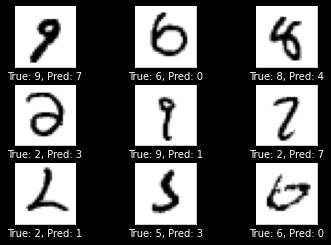

Confusion Matrix:
[[ 970    0    1    0    0    0    3    1    4    1]
 [   0 1127    3    0    0    0    0    0    5    0]
 [   4    8  999    7    3    0    0    4    7    0]
 [   1    0    1  997    0    1    0    4    5    1]
 [   0    1    1    0  970    0    1    2    3    4]
 [   1    2    0   12    2  864    4    2    3    2]
 [   7    3    0    0    7    2  932    0    7    0]
 [   0    5    7    5    0    0    0 1008    1    2]
 [   6    0    1    6    2    0    2    2  954    1]
 [   3    7    0    4    7    2    0    9    2  975]]


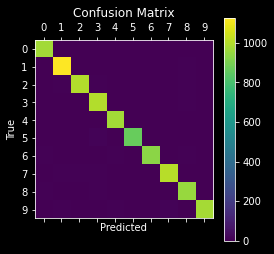

In [21]:
# Using the CNN
print("Total iterations:", total_iterations)
print_test_accuracy()

optimize(num_iterations=1)
print("Total iterations:", total_iterations)
print_test_accuracy()

optimize(num_iterations=99) # We already performed 1 iteration above.
print("Total iterations:", total_iterations)
print_test_accuracy(show_example_errors=True)

optimize(num_iterations=900) # We performed 100 iterations above.
print("Total iterations:", total_iterations)
print_test_accuracy(show_example_errors=True)

optimize(num_iterations=4000) # We performed 1000 iterations above.
print("Total iterations:", total_iterations)
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)